# Analysis Notebook

In [330]:
import pandas as pd
import os
import operator

os.chdir("/Users/bencampbell/code_louisville/capstone/louisville-bike-accidents/")

DATA = "data/clean/bike_accidents.csv"
assert os.path.exists(DATA)

df = pd.read_csv(DATA)
#df

## Questions

Do most accidents occur in intersections?

Do more or less accidents occur at *lighted* intersections?

Which roads are the most dangerous?
Are some parts of the road more dangerous than others. For example, is Bardstown Rd. more or less dangerous in the Highlands vs. further south? Shelbyville road near the Malls?

What type of road is the most dangerous?

Which areas of town are the most dangerous to ride?

What time of day do accidents occur?

What day of the week do the most/least accidents occur?

What are the safest road condiditons to ride? 
Road conditions/weather/light/diretional analysis/manner of collision useful here. 

What's up with "secondary_collision"? Are these more dangerous and/or do they occur very often?

How do accident patterns change over the years? Are there more or less accidents now vs. 2010?

Hit and runs seem to involve a lot of fatalities. Are these types of accidents actually more dangerous?

Are accidents with more vehicles involved more deadly?

In [331]:
# Add some useful columns
# noninjury
df['noninjury'] = df['injury_indicator'].combine(df['fatality_indicator'], 
                               func=lambda x, y:(not x) and (not y))

dates = df['date'] = df['date'].apply(pd.Timestamp)
timesplit = dates.transform({name:operator.attrgetter(name) for name in "year month day hour minute".split()})
df = df.join(timesplit)



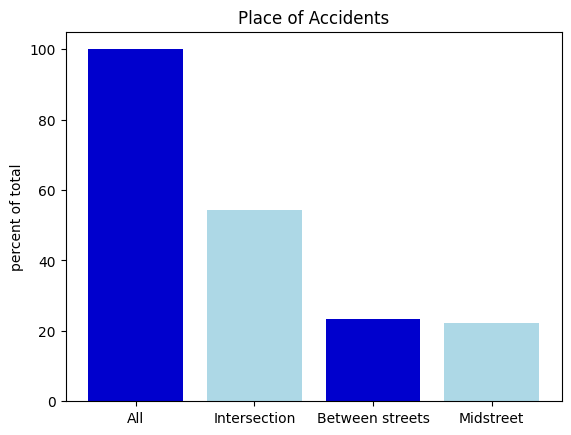

In [332]:
# Do more accidents occur in intersections?

total = len(df)

# Find accidents that are in intersections
intersection_accidents = df[df['intersection_roadway_name'].notna() | df['intersection_roadway_number'].notna()]
# Percent of accidents that occurred in intersections
pct_intersection_accidents = (len(intersection_accidents) / total) * 100

between_street_accidents = df[df['between_street_name_1'].notna() | df['between_street_name_2'].notna()]
pct_between_accidents = (len(between_street_accidents)/total) * 100

midstreet_accidents = total - len(between_street_accidents) - len(intersection_accidents)
# TODO Might there be some overlap between intersection accidents and between street accidents somehow?
pct_midstreet_accidents = (midstreet_accidents/total) * 100

import matplotlib.pyplot as graph

# x-coordinates of left sides of bars  
left = [1, 2, 3, 4] 
# heights of bars 
height = [100, pct_intersection_accidents, pct_between_accidents, pct_midstreet_accidents]
# labels for bars 
tick_label = ['All', 'Intersection', 'Between streets', 'Midstreet']
  
# plotting a bar chart 
graph.bar(left, height, tick_label = tick_label, 
        width = 0.8, color = ['mediumblue', 'lightblue'])   
# naming the x-axis 
#graph.xlabel('Place of accident') 
# naming the y-axis 
graph.ylabel('percent of total') 
# plot title 
graph.title('Place of Accidents') 
  
# function to show the plot 
graph.show() 

# TODO find a way to label bars

<Axes: xlabel='roadway_name'>

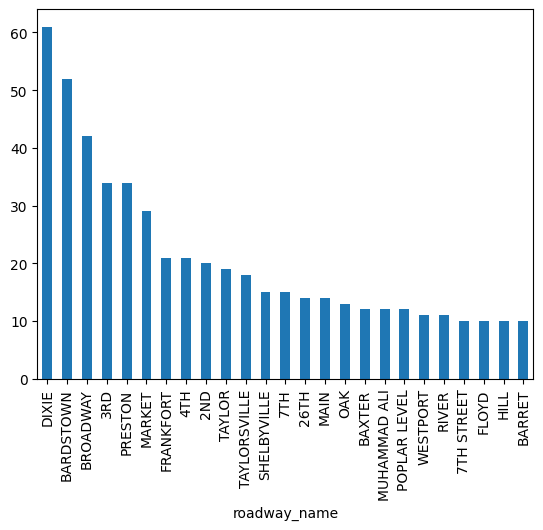

In [333]:
# Most dangerous roads?

top_most_dangerous_roads = df['roadway_name'].value_counts().head(25)
# TODO include numbered roadways into this. 
# Group by road type?
# Find percents by this: what percent of accidents occur in these most dangerous roads.
top_most_dangerous_roads.plot.bar()


In [334]:
road_names = df['roadway_name'].dropna().unique()
road_numbers = df['roadway_number'].dropna().unique()


df[df['roadway_name'].isna()] # Numbered roads with no name. Not too many.
# Make a new column 'roadway' for easier analyses.
def test(name, number):
    if pd.notnull(name):
        return name
    else:
        return number

df['roadway'] = df['roadway_name'].combine(df['roadway_number'], test)

In [335]:
#df[df['roadway'].isnull()] #-> empy DataFrame No records are null which is what I want.
import operator
road_group = df.groupby(by='roadway')
incidents = road_group[['injury_indicator', 'fatality_indicator']].sum()
incidents = incidents.rename({"injury_indicator":"injuries", "fatality_indicator":"fatalities"}, axis=1)
incidents['total'] = incidents['injuries'].combine(incidents['fatalities'], operator.add)

total_accidents = len(df)
total_incidents = len(incidents)
total_injuries = incidents['injuries'].sum()
total_fatalities = incidents['fatalities'].sum()

def get_percent(total):
    return lambda x:100*(x/total)

i = pd.concat((incidents, 
               incidents['injuries'].transform({
                    "injury_pct":get_percent(total_injuries),
                    "pct_injury_incidents":get_percent(total_incidents),
                    "pct_injury_accidents":get_percent(total_accidents)})
                ), axis=1)
i = pd.concat((i,
               incidents['fatalities'].transform({
                   "fatality_pct":get_percent(total_fatalities),
                   "pct_fatal_incidents":get_percent(total_incidents),
                   "pct_fatal_accidents":get_percent(total_accidents)})
                ), axis=1)

get_percent(total_accidents)(sum(incidents['fatalities']))
get_percent(total_accidents)(sum(incidents['injuries']))
get_percent(len(incidents))(sum(incidents['fatalities']))

7.264957264957266

In [336]:
worst_roads = df[df['roadway_name'].isin(top_most_dangerous_roads.index)]
worst_roads[['fatality_indicator', 'injury_indicator']].apply(lambda x:x.value_counts())

,fatality_indicator,injury_indicator
False,511,162
True,9,358


In [337]:
# Get % of accidents that occur on each road
# TODO incorporate numbered roadways into this.
hurt = df[['roadway_name', 'injury_indicator', 'fatality_indicator']]
hurt = hurt.groupby('roadway_name').sum()
totals = hurt['injury_indicator'] + hurt['fatality_indicator']
hurt['incidents'] = totals
hurt[hurt['incidents'] > 0].sort_values('incidents', ascending=False).head(20)


,injury_indicator,fatality_indicator,incidents
roadway_name,,,
DIXIE,51,2,53
BROADWAY,30,0,30
BARDSTOWN,26,2,28
PRESTON,24,3,27
MARKET,19,0,19
TAYLORSVILLE,18,0,18
3RD,18,0,18
4TH,17,0,17
2ND,14,0,14


In [338]:
# Most dangerous roads

def top_pct_value(df, column_name, pct):
    series = df[column_name]
    

In [339]:
# Most dangerous time to ride.
hours = pd.DataFrame(df.groupby('hour')[['injury_indicator', 'fatality_indicator', 'noninjury']].sum())
hours['total'] = pd.Series(df.groupby('hour').size())

hours

,injury_indicator,fatality_indicator,noninjury,total
hour,,,,
0,46,2,22,70
1,12,3,0,15
2,2,1,1,4
3,6,0,0,6
4,1,5,2,8
5,9,0,2,11
6,25,0,4,29
7,23,1,12,36
8,23,0,10,33


# Time of Day

<Axes: xlabel='hour of day', ylabel='accident count'>

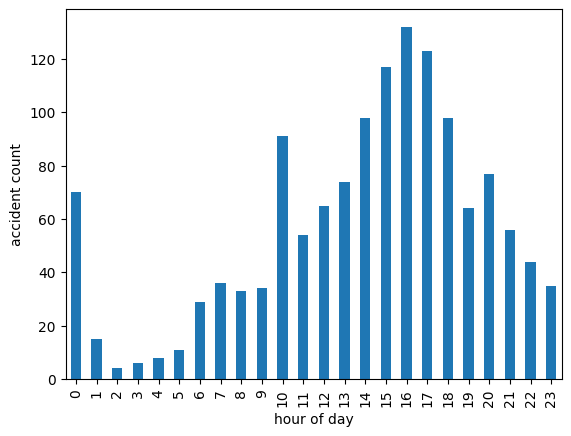

In [340]:
# Time of day
df.groupby('hour').size().plot(kind='bar', xlabel='hour of day', ylabel="accident count")


The graph above is a simple plot of the data, without any manipulation. I think there are outlier values for hour 0 (midnight). I suspect that the way accidents are reported and entered into this database, if a value for time is missing in the report, the time is entered as 00:00:00. In the next code cell I have some further evidence for this.

<Axes: xlabel='hour of day', ylabel='count of light_condition == DAYLIGHT'>

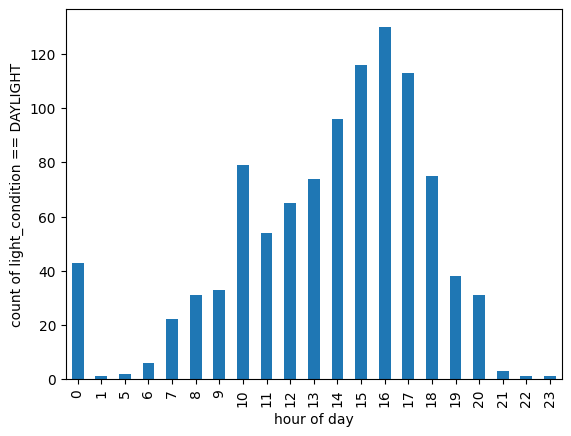

In [341]:
hour_light = df[['hour', 'light_condition']]
hour_light[hour_light['light_condition'] == "DAYLIGHT"].groupby('hour').size().plot(
    kind='bar', xlabel='hour of day', ylabel='count of light_condition == DAYLIGHT')

Definitely an unusual distribution. I would expect the light_condition value to be DAYLIGHT only during normal daylight hours. There are some other outliers to address. Louisville is well below the Arctic Circle, so 1 AM is dark all year, for example. 

In any case, a significant number of records with hour near or equal to 0 report daylight light conditions. I'll exclude my data from my analysis of the time here. 

Now I'll take a look at records where the time has a zero value to see what data I can ignore.

In [342]:
zeros = df[(df.hour==0) & (df.minute==0)]
# Get all rows that have 00:00 time value

#zeros[zeros['date'].apply(lambda x:x.second==0)]
# Check that the seconds are zero too.

zeros_index = zeros[zeros['light_condition'] == "DAYLIGHT"].index
# For recrods that have 00:00 time, find the ones that have light_condition == DAYLIGHT, 
# then filter these records out of my data:

filtered_light = df[~df.index.isin(zeros_index)]
daylight = filtered_light[filtered_light['light_condition'] == "DAYLIGHT"]

daylight_corrections = daylight[daylight['hour'].isin([0,1,22,23])].index
# removing some more outlier values.
# These are records at midnit, 1AM, 10PM, and 11PM where light_condition == DAYLIGHT
# It is conceivable that at the height of Summer someone could report light condition as "daylight" in this location,
# but I'm going to ignore it anyway. If I wanted to be thorough, I'd check the time of year. If this report isn't 
# from Summer, it's definitely not correct. 

daylight = daylight[~daylight.index.isin(daylight_corrections)]

<Axes: xlabel='hour of day', ylabel='DAYLIGHT'>

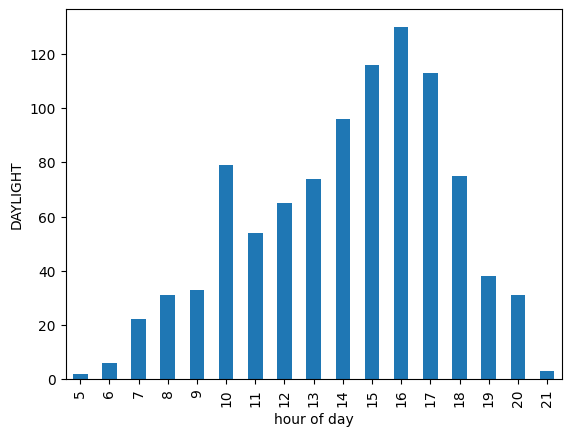

In [343]:
# Now let's see what the time distribution for DAYLIGHT condition looks like:
daylight.groupby('hour').size().plot(kind='bar', ylabel='DAYLIGHT', xlabel='hour of day')


This is much more in line with what I would expect.

I tried to make the next plot a little more granular. This plot is not pretty or easy to read but it does make some patterns more clear. 


# todo  OTHER TIMES OF DAY
DAWN DUSK NIGHT DARK

748     2014-05-27 05:54:00-04:00
1043    2016-05-11 05:46:00-04:00
Name: date, dtype: object

46      2010-06-03 21:01:00-04:00
65      2010-07-03 21:00:00-04:00
1067    2016-07-15 21:06:00-04:00
Name: date, dtype: object

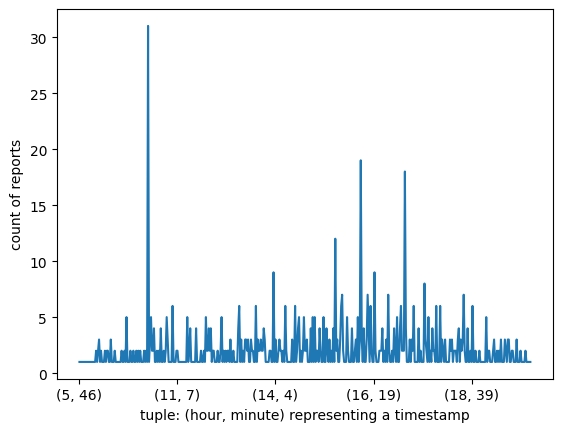

In [344]:
daylight.groupby(['hour', 'minute']).size().plot(xlabel="tuple: (hour, minute) representing a timestamp",
                                                 ylabel='count of reports')
# What's with the huge spike at 10 AM?
# HH:00 seems to be the default way to report the time of accident.

# These seem like reasonable times to see daylight. Future idea: correlate the time of year with average day length for precise day-light cycle information on tap.
display(
    daylight[daylight.hour==5].date, # late 5 o'clock, May
    daylight[daylight.hour==21].date # early 9 o'clock, Summer
)

Unfortunately, there is still a major issue with the data: we do not know how many people are cycling at different times of day. Cyclists tend to avoid riding at night. So, while there are low numbers of accidents at 3 AM, that may only reflect the relatively low number of cyclists riding at that hour, and not the actual danger of that hour to ride as a ratio of riders to accident reports. 

Similarly, we see a very high number of accidents at 3 PM. It may not be the case that 3 PM is an exceptionally dangerous time to ride. There are many cyclists on the road at this time, therefore there are more opportunities for accidents vs. the small number of cyclists who ride at night. 

<Axes: xlabel='hour of day'>

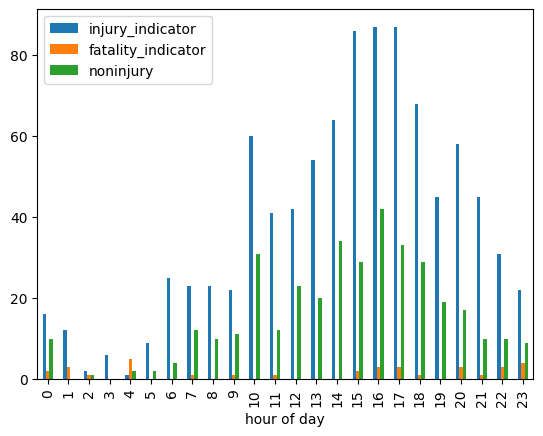

In [345]:
hourly_summary = filtered_light.groupby('hour')[['injury_indicator', 'fatality_indicator', 'noninjury']].sum()

hourly_summary.plot(kind='bar', xlabel='hour of day')

# TODO matplotlib find a better tpe fo chart for this. 

One way to determine how dangerous it is to ride a bicycle at at a certain time of day is to take the ratio of the count of bicycle accidents to the count of cyclists for a given time and compare. Since I do not have data on riders per time of day, this is not yet possible. However, I can look at the ratios of injuries and fatalities to total accidents.

In [346]:
hourly_summary.agg(["sum"])
hourly_summary.agg("sum") # slightly different results. Interesting. 

injury_indicator      929
fatality_indicator     34
noninjury             370
dtype: int64

<Axes: xlabel='hour'>

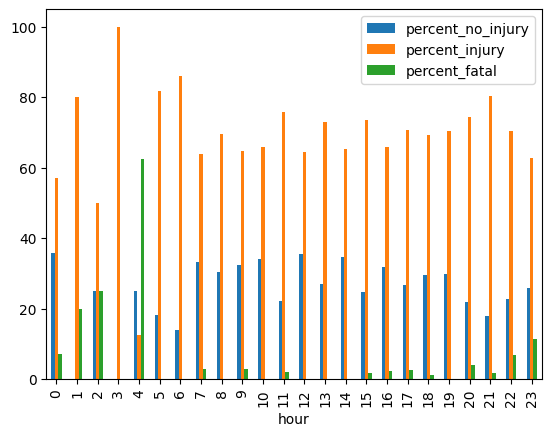

In [347]:
hourly_summary['total'] = hourly_summary[['injury_indicator', 'fatality_indicator', 'noninjury']].apply(sum, axis=1)
#hourly_summary

hs = hourly_summary
hs['percent_injury'] = (hs['injury_indicator']/ hourly_summary['total'] * 100).apply(lambda x:round(x, 2))
hs['percent_fatal'] = (hs['fatality_indicator']/hourly_summary['total'] * 100).apply(lambda x:round(x, 2))
hs['percent_no_injury'] = (hs['noninjury']/hourly_summary['total'] * 100).apply(lambda x:round(x, 2))

hs = hs.rename({'injury_indicator': 'sum_injury', 
                'fatality_indicator': 'sum_fatality', 
                'noninjury': 'sum_no_injury'}, axis=1)
hs[['percent_no_injury', 'percent_injury', 'percent_fatal']].plot.bar()


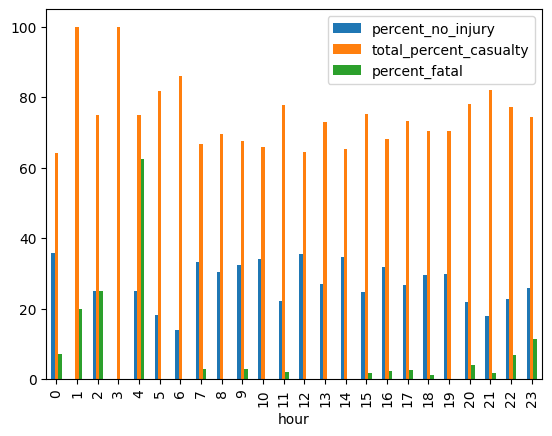

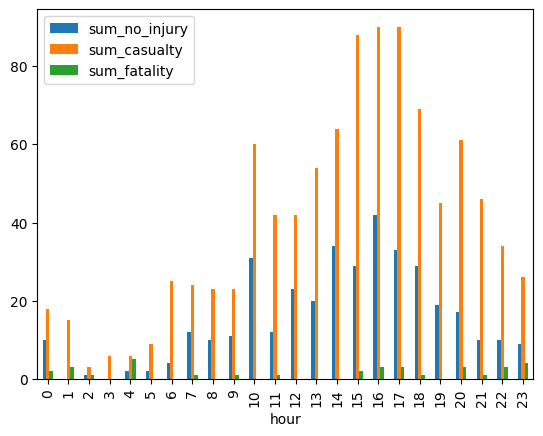

In [348]:
def grapho(frame, color=None):
    frame['total_percent_casualty'] = (frame['percent_fatal'] + frame['percent_injury'])
    frame[['percent_no_injury', 'total_percent_casualty', 'percent_fatal']].plot.bar(color=color)

    frame['sum_casualty'] = frame['sum_fatality'] + frame['sum_injury']
    frame[['sum_no_injury', 'sum_casualty', 'sum_fatality']].plot.bar(color=color)

grapho(hs)

# TODO fix colors

In [349]:
night_hours = df[~df.index.isin(daylight.index)].index
daylight_hours = daylight.index
daylight['light_condition']

1       DAYLIGHT
2       DAYLIGHT
3       DAYLIGHT
4       DAYLIGHT
5       DAYLIGHT
          ...   
1368    DAYLIGHT
1369    DAYLIGHT
1370    DAYLIGHT
1371    DAYLIGHT
1372    DAYLIGHT
Name: light_condition, Length: 968, dtype: object

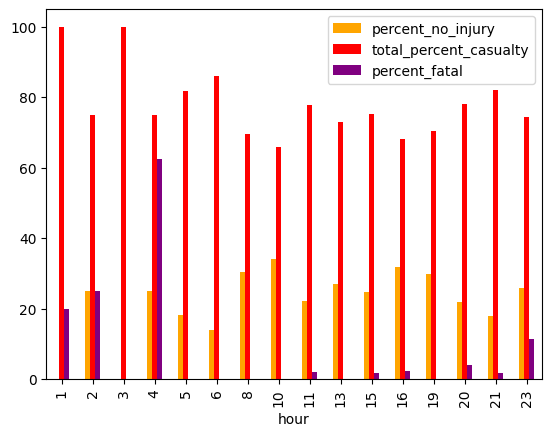

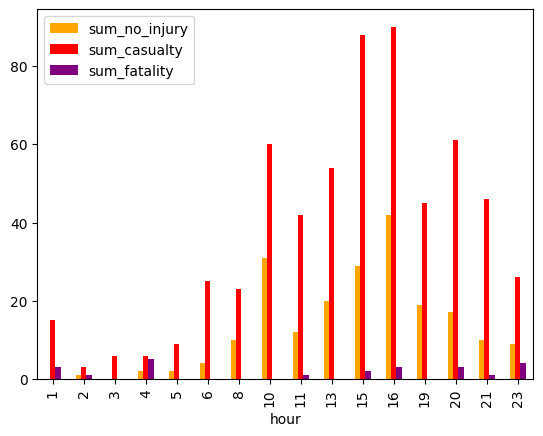

In [350]:
day = pd.DataFrame(hs[hs.index.isin(daylight_hours)])

grapho(day, color='orange red purple'.split())

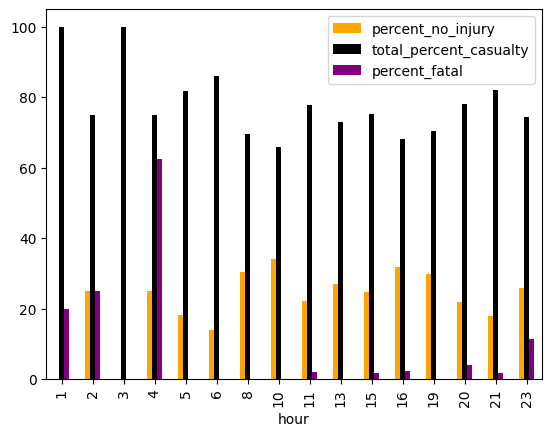

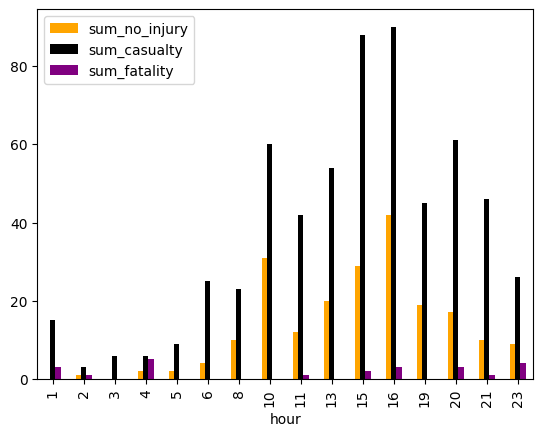

In [351]:
night = pd.DataFrame(hs[~hs.index.isin(night_hours)])

grapho(night, 'orange black purple'.split())

In [387]:
#df[df.index.isin(zeros_index)].light_condition.value_counts() # Checking: Still exclude these
exclude = pd.Index(zeros_index)

Index([  31,   87,   95,   98,  101,  104,  109,  138,  171,  178,  189,  211,
        234,  334,  341,  349,  396,  479,  574,  578,  600,  602,  615,  670,
        709,  710,  711,  743,  786,  867,  882,  962,  979,  981,  997, 1045,
       1106, 1114, 1155, 1165, 1177, 1218],
      dtype='int64')

In [416]:

filtered_dark = df[(df['light_condition'] != 'DAYLIGHT')]

# Night time unusual records
filtered_dark[filtered_dark.light_condition == 'OTHER'] # Fine
exclude.append(filtered_dark[filtered_dark.hour == 15].index) # light condition == DAWN. Not nighttime. Exclude
exclude.append(filtered_dark[filtered_dark.hour == 14].index)
exclude.append(filtered_dark[filtered_dark.hour == 10].index) # Exclude.
exclude.append(filtered_dark[filtered_dark.hour.isin([8,9,16])].index)

dark = filtered_dark[~filtered_dark.index.isin(exclude)]


In [440]:
night_summary = filtered_light.groupby('hour')[['injury_indicator', 'fatality_indicator', 'noninjury']].sum()
night_summary['total'] = night_summary[['injury_indicator', 'fatality_indicator', 'noninjury']].apply(sum, axis=1)
night_summary



,injury_indicator,fatality_indicator,noninjury,total
hour,,,,
0,16,2,10,28
1,12,3,0,15
2,2,1,1,4
3,6,0,0,6
4,1,5,2,8
5,9,0,2,11
6,25,0,4,29
7,23,1,12,36
8,23,0,10,33


<Axes: xlabel='hour'>

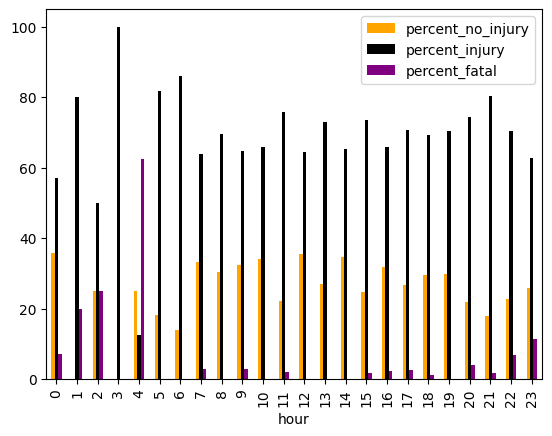

In [442]:

ns = night_summary
ns['percent_injury'] = (ns['injury_indicator']/ ns['total'] * 100).apply(lambda x:round(x, 2))
ns['percent_fatal'] = (ns['fatality_indicator']/ns['total'] * 100).apply(lambda x:round(x, 2))
ns['percent_no_injury'] = (ns['noninjury']/ns['total'] * 100).apply(lambda x:round(x, 2))

ns = ns.rename({'injury_indicator': 'sum_injury', 
                'fatality_indicator': 'sum_fatality', 
                'noninjury': 'sum_no_injury'}, axis=1)
ns[['percent_no_injury', 'percent_injury', 'percent_fatal']].plot.bar(color='orange black purple'.split())


In [428]:
night_summary = filtered_light.groupby('hour')[['injury_indicator', 'fatality_indicator', 'noninjury']].sum()
night_summary

,injury_indicator,fatality_indicator,noninjury
hour,,,
0,16,2,10
1,12,3,0
2,2,1,1
3,6,0,0
4,1,5,2
5,9,0,2
6,25,0,4
7,23,1,12
8,23,0,10
